<a href="https://colab.research.google.com/github/aakashxtha/lysozyme-md-analysis/blob/main/MD_Assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Molecular Dynamics and Pocket Analysis

## Objective
This assessment demonstrates a systematic approach to analyzing protein binding pockets using molecular dynamics simulations. The goal is to characterize static binding sites and compare them with dynamic behavior observed during MD simulations.


## Methods
1. **Environment setup** - Configure GROMACS and fpocket for computational analysis
2. **Structure preparation** - Process target protein structure for analysis
3. **Static pocket analysis** - Identify baseline binding sites using fpocket
4. **MD simulation** - Observe protein dynamics over 10 ns timescale
5. **Comparative analysis** - Evaluate dynamic pocket behavior

---

## 1. Software Installation & Setup

Installing GROMACS with CUDA support for GPU acceleration and fpocket for cavity detection.

In [ ]:
# Update system and install basic tools
!apt-get update -qq
!apt-get install -y wget curl build-essential

# Install conda (if needed)
!which conda || (wget -q https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh && chmod +x Miniconda3-latest-Linux-x86_64.sh && ./Miniconda3-latest-Linux-x86_64.sh -b -p /content/miniconda3)

# Add conda to PATH
import os
os.environ['PATH'] = '/content/miniconda3/bin:' + os.environ['PATH']


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
curl is already the newest version (7.81.0-1ubuntu1.20).
wget is already the newest version (1.21.2-2ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
ERROR: File or directory already exists: '/content/miniconda3'
If you want to update an existing installation, use the -u option.


In [ ]:
# Install GROMACS and fpocket
!conda update conda -y
!conda install -c conda-forge gromacs=2023.3=*cuda* fpocket -y

Channels:
 - defaults
Platform: linux-64
Solving environment: \ | done

# All requested packages already installed.

Channels:
 - conda-forge
 - defaults
Platform: linux-64
Solving environment: / - done

# All requested packages already installed.



In [ ]:
# Configure environment variables for optimal GROMACS performance
os.environ['GMX_MAXBACKUP'] = '-1'
os.environ['GMX_SUPPRESS_DUMP'] = '1'
os.environ['OMP_NUM_THREADS'] = '2'

In [ ]:
# Verify installation
!gmx --version | head -3
!fpocket --help | head -3

# Create workspace
!mkdir -p MD_Assessment_Results/{input,analysis,pockets}
os.chdir('MD_Assessment_Results')

                   :-) GROMACS - gmx, 2023.3-conda_forge (-:

Executable:   /content/miniconda3/bin.AVX2_256/gmx
***** POCKET HUNTING BEGINS ***** 
! Invalid pdb name given.



## 2. Target Protein Selection and Preparation

### Protein Selection Criteria
Lysozyme (PDB: 1AKI) was selected as the target protein based on:
- Well-characterized structure and binding sites
- Appropriate size for computational feasibility  
- Extensive validation data available in literature
- Known stability for MD simulations

In [ ]:
# Download target structure
!wget https://files.rcsb.org/download/1AKI.pdb -O input/protein.pdb
!head -5 input/protein.pdb

--2025-06-10 21:28:10--  https://files.rcsb.org/download/1AKI.pdb
Resolving files.rcsb.org (files.rcsb.org)... 18.154.144.109, 18.154.144.39, 18.154.144.12, ...
Connecting to files.rcsb.org (files.rcsb.org)|18.154.144.109|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘input/protein.pdb’

input/protein.pdb       [ <=>                ] 113.67K  --.-KB/s    in 0.09s   

2025-06-10 21:28:11 (1.21 MB/s) - ‘input/protein.pdb’ saved [116397]

HEADER    HYDROLASE                               19-MAY-97   1AKI              
TITLE     THE STRUCTURE OF THE ORTHORHOMBIC FORM OF HEN EGG-WHITE LYSOZYME AT   
TITLE    2 1.5 ANGSTROMS RESOLUTION                                             
COMPND    MOL_ID: 1;                                                            
COMPND   2 MOLECULE: LYSOZYME;                                                  


### Structure Processing
Raw PDB files contain crystallographic waters, ions, and artifacts that must be removed for consistent analysis.

In [ ]:
# Extract protein atoms only
!grep "^ATOM" input/protein.pdb > input/protein_clean.pdb

# Cleaning results
original_lines = len(open('input/protein.pdb').readlines())
clean_lines = len(open('input/protein_clean.pdb').readlines())
print(f"Structure cleaning removed {original_lines - clean_lines} non-protein entries")

Structure cleaning removed 436 non-protein entries


In [ ]:
#Visualization
!pip install py3Dmol
import py3Dmol

with open('input/protein_clean.pdb', 'r') as f:
    pdb_data = f.read()

view = py3Dmol.view(width=600, height=400)
view.addModel(pdb_data, 'pdb')
view.setStyle({'cartoon': {'color': 'blue'}})
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## 3. Static Pocket Analysis

Fpocket ranks pockets by druggability score considering volume, hydrophobicity, and geometric properties. This provides quantitative baseline data for comparison with dynamic analysis.

In [ ]:
# Perform cavity detection on static structure
!fpocket -f input/protein_clean.pdb
!mv input/protein_clean_out pockets/static

***** POCKET HUNTING BEGINS ***** 
***** POCKET HUNTING ENDS ***** 


In [ ]:
# Extract key pocket properties
with open('pockets/static/protein_clean_info.txt', 'r') as f:
    lines = f.readlines()

print("Best pocket characteristics:")
for line in lines[:10]:
    if any(keyword in line for keyword in ['Pocket', 'Score', 'Volume', 'Druggability']):
        print(line.strip())

Best pocket characteristics:
Pocket 1 :
Score : 	0.441
Druggability Score : 	0.112
Volume : 	506.287


In [ ]:
#Visualize best pocket detected
with open('input/protein_clean.pdb', 'r') as f:
   protein_data = f.read()

view = py3Dmol.view(width=600, height=400)
view.addModel(protein_data, 'pdb')
view.setStyle({}, {'stick': {'color': 'blue'}})

with open('pockets/static/pockets/pocket1_atm.pdb', 'r') as f:
   pocket_data = f.read()
view.addModel(pocket_data, 'pdb')
view.setStyle({'model': 1}, {'sphere': {'color': 'red', 'radius': 0.5}})

view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## 4. Molecular Dynamics Simulation

### Parameter Selection
The following simulation parameters were chosen based on established best practices:

**Parameter:**
- **OPLS-AA force field:** Well-validated for protein simulations
- **2 fs timestep:** Standard for constrained bond simulations
- **10 ns duration:** Sufficient for pocket dynamics (Also I had limited computational resources so I chose 10 ns rather than 100 ns)

In [ ]:
# Energy minimization parameters
em_mdp = """integrator  = steep
emtol       = 1000.0
emstep      = 0.01
nsteps      = 50000
cutoff-scheme = Verlet
coulombtype = PME
rcoulomb    = 1.0
rvdw        = 1.0
pbc         = xyz"""

# NVT equilibration (temperature control)
nvt_mdp = """integrator  = md
nsteps      = 50000
dt          = 0.002
tcoupl      = V-rescale
tc-grps     = Protein Non-Protein
tau-t       = 0.1     0.1
ref-t       = 300     300
constraints = all-bonds
cutoff-scheme = Verlet
coulombtype = PME
rcoulomb    = 1.0
rvdw        = 1.0
pbc         = xyz"""

# NPT equilibration (pressure control)
npt_mdp = """integrator  = md
nsteps      = 50000
dt          = 0.002
tcoupl      = V-rescale
tc-grps     = Protein Non-Protein
tau-t       = 0.1     0.1
ref-t       = 300     300
pcoupl      = Parrinello-Rahman
pcoupltype  = isotropic
tau-p       = 2.0
ref-p       = 1.0
compressibility = 4.5e-5
constraints = all-bonds
cutoff-scheme = Verlet
coulombtype = PME
rcoulomb    = 1.0
rvdw        = 1.0
pbc         = xyz"""

# Production MD simulation (10 ns)
md_mdp = """integrator  = md
nsteps      = 5000000
dt          = 0.002
nstxout-compressed = 5000
nstenergy   = 5000
nstlog      = 5000
tcoupl      = V-rescale
tc-grps     = Protein Non-Protein
tau-t       = 0.1     0.1
ref-t       = 300     300
pcoupl      = Parrinello-Rahman
pcoupltype  = isotropic
tau-p       = 2.0
ref-p       = 1.0
compressibility = 4.5e-5
constraints = all-bonds
cutoff-scheme = Verlet
coulombtype = PME
rcoulomb    = 1.0
rvdw        = 1.0
pbc         = xyz"""

# Generate parameter files
for name, content in [('em.mdp', em_mdp), ('nvt.mdp', nvt_mdp), ('npt.mdp', npt_mdp), ('md.mdp', md_mdp)]:
    with open(name, 'w') as f:
        f.write(content)

### System Preparation

The final system contains the protein, explicit water molecules, and counterions in a cubic periodic box with 1.0 nm minimum protein-boundary distance.

In [ ]:
# Generate molecular topology
!echo -e "15\n7" | gmx pdb2gmx -f input/protein_clean.pdb -o protein_processed.gro -p topol.top -i posre.itp

               :-) GROMACS - gmx pdb2gmx, 2023.3-conda_forge (-:

Executable:   /content/miniconda3/bin.AVX2_256/gmx
Data prefix:  /content/miniconda3
Working dir:  /content/md_work
Command line:
  gmx pdb2gmx -f input/protein_clean.pdb -o protein_processed.gro -p topol.top -i posre.itp

Select the Force Field:

From '/content/miniconda3/share/gromacs/top':

 1: AMBER03 protein, nucleic AMBER94 (Duan et al., J. Comp. Chem. 24, 1999-2012, 2003)

 2: AMBER94 force field (Cornell et al., JACS 117, 5179-5197, 1995)

 3: AMBER96 protein, nucleic AMBER94 (Kollman et al., Acc. Chem. Res. 29, 461-469, 1996)

 4: AMBER99 protein, nucleic AMBER94 (Wang et al., J. Comp. Chem. 21, 1049-1074, 2000)

 5: AMBER99SB protein, nucleic AMBER94 (Hornak et al., Proteins 65, 712-725, 2006)

 6: AMBER99SB-ILDN protein, nucleic AMBER94 (Lindorff-Larsen et al., Proteins 78, 1950-58, 2010)

 7: AMBERGS force field (Garcia & Sanbonmatsu, PNAS 99, 2782-2787, 2002)

 8: CHARMM27 all-atom force field (CHARM22 plus 

In [ ]:
# Create simulation box and solvate
!gmx editconf -f protein_processed.gro -o newbox.gro -bt cubic -d 1.0
!gmx solvate -cp newbox.gro -cs spc216.gro -p topol.top -o solv.gro

               :-) GROMACS - gmx editconf, 2023.3-conda_forge (-:

Executable:   /content/miniconda3/bin.AVX2_256/gmx
Data prefix:  /content/miniconda3
Working dir:  /content/md_work
Command line:
  gmx editconf -f protein_processed.gro -o newbox.gro -bt cubic -d 1.0

Note that major changes are planned in future for editconf, to improve usability and utility.
Read 1960 atoms
Volume: 55.8378 nm^3, corresponds to roughly 25100 electrons
No velocities found
    system size :  3.817  4.234  3.454 (nm)
    diameter    :  5.010               (nm)
    center      :  2.781  2.488  0.017 (nm)
    box vectors :  3.817  4.235  3.455 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
    box volume  :  55.84               (nm^3)
    shift       :  0.724  1.017  3.488 (nm)
new center      :  3.505  3.505  3.505 (nm)
new box vectors :  7.010  7.010  7.010 (nm)
new box angles  :  90.00  90.00  90.00 (degrees)
new box volume  : 344.48               (nm^3)

GROMACS reminds you: "During my undergrad

In [ ]:
# Add counterions for system neutrality
!gmx grompp -f em.mdp -c solv.gro -p topol.top -o ions.tpr -maxwarn 1
!echo "13" | gmx genion -s ions.tpr -o solv_ions.gro -p topol.top -pname NA -nname CL -neutral

print("Final system composition:")
!tail -3 solv_ions.gro

                :-) GROMACS - gmx grompp, 2023.3-conda_forge (-:

Executable:   /content/miniconda3/bin.AVX2_256/gmx
Data prefix:  /content/miniconda3
Working dir:  /content/md_work
Command line:
  gmx grompp -f em.mdp -c solv.gro -p topol.top -o ions.tpr -maxwarn 1

Setting the LD random seed to -1075889427

Generated 330891 of the 330891 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 0.5

Generated 330891 of the 330891 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

Excluding 2 bonded neighbours molecule type 'SOL'

NOTE 1 [file topol.top, line 18409]:
  System has non-zero total charge: 8.000000
  Total charge should normally be an integer. See
  http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
  for discussion on how close it should be to an integer.




WARNING 1 [file topol.top, line 18409]:
  You are using Ewald electrostatics in a system with net charge. This can
  lead to severe artifacts, such as

In [ ]:
# Visualize solvated system
!echo "0" | gmx editconf -f solv_ions.gro -o solvated_vis.pdb

with open('solvated_vis.pdb', 'r') as f:
   solvated_data = f.read()

view.addModel(solvated_data, 'pdb')
view.setStyle({'resn': ['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL']}, {'cartoon': {'color': 'blue'}})
view.setStyle({'resn': 'SOL', 'atom': 'OW'}, {'sphere': {'color': 'red', 'radius': 0.2, 'opacity': 0.3}})
view.setStyle({'resn': ['NA', 'CL']}, {'sphere': {'color': 'yellow', 'radius': 0.4}})
view.zoomTo()
view.show()

               :-) GROMACS - gmx editconf, 2023.3-conda_forge (-:

Executable:   /content/miniconda3/bin.AVX2_256/gmx
Data prefix:  /content/miniconda3
Working dir:  /content/drive/MyDrive/MD_Assessment_Results
Command line:
  gmx editconf -f solv_ions.gro -o solvated_vis.pdb

Note that major changes are planned in future for editconf, to improve usability and utility.
Read 33876 atoms
Volume: 344.484 nm^3, corresponds to roughly 155000 electrons
No velocities found

GROMACS reminds you: "Two chemists walk into a bar. The first one says, 'I'll have some H2O.'. The second one says, 'I'll have some H2O, too'. He dies." (Anonymous)



3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## MD Simulation Execution



In [ ]:
# Energy Minimization
!gmx grompp -f em.mdp -c solv_ions.gro -p topol.top -o em.tpr
!gmx mdrun -v -deffnm em -nb gpu -ntmpi 1 -ntomp 2

                :-) GROMACS - gmx grompp, 2023.3-conda_forge (-:

Executable:   /content/miniconda3/bin.AVX2_256/gmx
Data prefix:  /content/miniconda3
Working dir:  /content/md_work
Command line:
  gmx grompp -f em.mdp -c solv_ions.gro -p topol.top -o em.tpr

Setting the LD random seed to -1649737761

Generated 330891 of the 330891 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 0.5

Generated 330891 of the 330891 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

Excluding 2 bonded neighbours molecule type 'SOL'

Excluding 1 bonded neighbours molecule type 'CL'
Analysing residue names:
There are:   129    Protein residues
There are: 10636      Water residues
There are:     8        Ion residues
Analysing Protein...
Number of degrees of freedom in T-Coupling group rest is 69717.00
The integrator does not provide a ensemble temperature, there is no system ensemble temperature

The largest distance between excluded atoms is 0

In [ ]:
# NVT Equilibration (100 ps)
!gmx grompp -f nvt.mdp -c em.gro -r em.gro -p topol.top -o nvt.tpr
!gmx mdrun -v -deffnm nvt -nb gpu -pme gpu

                :-) GROMACS - gmx grompp, 2023.3-conda_forge (-:

Executable:   /content/miniconda3/bin.AVX2_256/gmx
Data prefix:  /content/miniconda3
Working dir:  /content/md_work
Command line:
  gmx grompp -f nvt.mdp -c em.gro -r em.gro -p topol.top -o nvt.tpr

Setting the LD random seed to -438928505

Generated 330891 of the 330891 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 0.5

Generated 330891 of the 330891 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

turning all bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning all bonds into constraints...

Excluding 1 bonded neighbours molecule type 'CL'

turning all bonds into constraints...

NOTE 1 [file unknown]:
  You are using constraints on all bonds, whereas the forcefield has been
  parametrized only with constraints involving hydrogen atoms. We suggest
  using constraints = h-bonds instead, this will also improve performance.


In [ ]:
# NPT Equilibration (100 ps)
!gmx grompp -f npt.mdp -c nvt.gro -r nvt.gro -p topol.top -o npt.tpr
!gmx mdrun -v -deffnm npt -nb gpu -pme gpu

                :-) GROMACS - gmx grompp, 2023.3-conda_forge (-:

Executable:   /content/miniconda3/bin.AVX2_256/gmx
Data prefix:  /content/miniconda3
Working dir:  /content/md_work
Command line:
  gmx grompp -f npt.mdp -c nvt.gro -r nvt.gro -p topol.top -o npt.tpr

Setting the LD random seed to -36737625

Generated 330891 of the 330891 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 0.5

Generated 330891 of the 330891 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

turning all bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning all bonds into constraints...

Excluding 1 bonded neighbours molecule type 'CL'

turning all bonds into constraints...

NOTE 1 [file unknown]:
  You are using constraints on all bonds, whereas the forcefield has been
  parametrized only with constraints involving hydrogen atoms. We suggest
  using constraints = h-bonds instead, this will also improve performance.

In [ ]:
# 10 ns Production Run
!gmx grompp -f md.mdp -c npt.gro -t npt.cpt -p topol.top -o md.tpr
!gmx mdrun -v -deffnm md -nb gpu -pme gpu

print("MD simulation completed successfully")

                :-) GROMACS - gmx grompp, 2023.3-conda_forge (-:

Executable:   /content/miniconda3/bin.AVX2_256/gmx
Data prefix:  /content/miniconda3
Working dir:  /content/md_work
Command line:
  gmx grompp -f md.mdp -c npt.gro -t npt.cpt -p topol.top -o md.tpr

Setting the LD random seed to -2785409

Generated 330891 of the 330891 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 0.5

Generated 330891 of the 330891 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

turning all bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning all bonds into constraints...

Excluding 1 bonded neighbours molecule type 'CL'

turning all bonds into constraints...

NOTE 1 [file unknown]:
  You are using constraints on all bonds, whereas the forcefield has been
  parametrized only with constraints involving hydrogen atoms. We suggest
  using constraints = h-bonds instead, this will also improve performance.

A

## 5. Trajectory Analysis

Now let's dive into what actually happened during our 10 ns simulation. I want to understand:

- How stable was the protein overall?
- Which parts moved the most?
- How did the binding pockets behave?
- What does this mean for drug design?

---

## 5.1 Overall Protein Stability
**RMSD Calculation**

                 :-) GROMACS - gmx rms, 2023.3-conda_forge (-:

Executable:   /content/miniconda3/bin.AVX2_256/gmx
Data prefix:  /content/miniconda3
Working dir:  /content/drive/MyDrive/MD_Assessment_Results
Command line:
  gmx rms -s md.tpr -f md.xtc -o rmsd_protein.xvg -tu ns

Reading file md.tpr, VERSION 2023.3-conda_forge (single precision)
Reading file md.tpr, VERSION 2023.3-conda_forge (single precision)
Select group for least squares fit
Group     0 (         System) has 33876 elements
Group     1 (        Protein) has  1960 elements
Group     2 (      Protein-H) has  1001 elements
Group     3 (        C-alpha) has   129 elements
Group     4 (       Backbone) has   387 elements
Group     5 (      MainChain) has   517 elements
Group     6 (   MainChain+Cb) has   634 elements
Group     7 (    MainChain+H) has   646 elements
Group     8 (      SideChain) has  1314 elements
Group     9 (    SideChain-H) has   484 elements
Group    10 (    Prot-Masses) has  1960 elements
Group    11 

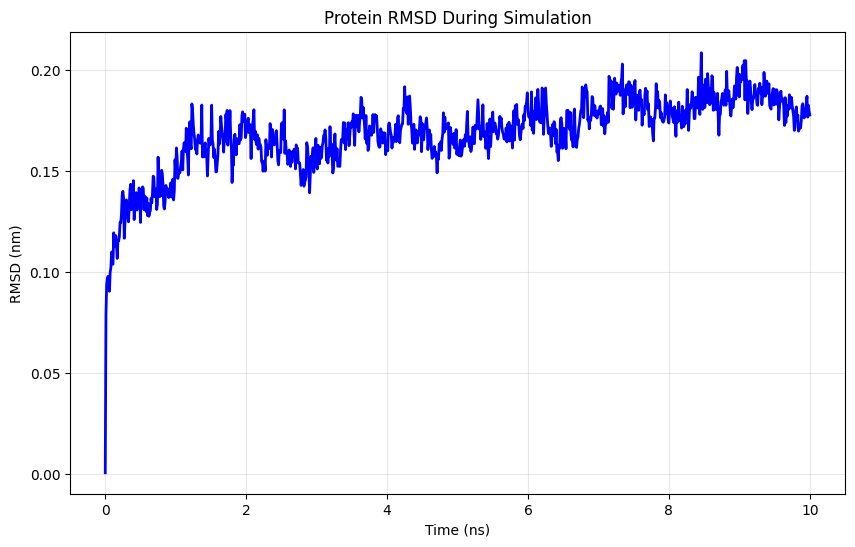

Final RMSD: 0.178 nm
Average RMSD: 0.169 nm


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

with open('rmsd_input.txt', 'w') as f:
    f.write('1\n1\n')

!gmx rms -s md.tpr -f md.xtc -o rmsd_protein.xvg -tu ns < rmsd_input.txt

# Read and plot the data
def parse_xvg(filename):
    time, values = [], []
    try:
        with open(filename, 'r') as f:
            for line in f:
                if not line.startswith('#') and not line.startswith('@'):
                    data = line.split()
                    if len(data) >= 2:
                        time.append(float(data[0]))
                        values.append(float(data[1]))
        return np.array(time), np.array(values)
    except Exception as e:
        print(f"Error reading file: {e}")
        return np.array([]), np.array([])

time_data, rmsd_data = parse_xvg('rmsd_protein.xvg')

if len(rmsd_data) > 0:
    plt.figure(figsize=(10, 6))
    plt.plot(time_data, rmsd_data, 'b-', linewidth=2)
    plt.xlabel('Time (ns)')
    plt.ylabel('RMSD (nm)')
    plt.title('Protein RMSD During Simulation')
    plt.grid(True, alpha=0.3)
    plt.savefig('analysis/rmsd_analysis.png', dpi=300)
    plt.show()

    final_rmsd = rmsd_data[-1]
    avg_rmsd = np.mean(rmsd_data)

    print(f"Final RMSD: {final_rmsd:.3f} nm")
    print(f"Average RMSD: {avg_rmsd:.3f} nm")
else:
    print("RMSD calculation failed")

The RMSD values under 0.3 nm that means the protein kept its overall shape throughout the simulation

-----

**RMSF Calculation**


                 :-) GROMACS - gmx rmsf, 2023.3-conda_forge (-:

Executable:   /content/miniconda3/bin.AVX2_256/gmx
Data prefix:  /content/miniconda3
Working dir:  /content/drive/MyDrive/MD_Assessment_Results
Command line:
  gmx rmsf -s md.tpr -f md.xtc -o rmsf_residue.xvg -res

Reading file md.tpr, VERSION 2023.3-conda_forge (single precision)
Reading file md.tpr, VERSION 2023.3-conda_forge (single precision)
Select group(s) for root mean square calculation
Group     0 (         System) has 33876 elements
Group     1 (        Protein) has  1960 elements
Group     2 (      Protein-H) has  1001 elements
Group     3 (        C-alpha) has   129 elements
Group     4 (       Backbone) has   387 elements
Group     5 (      MainChain) has   517 elements
Group     6 (   MainChain+Cb) has   634 elements
Group     7 (    MainChain+H) has   646 elements
Group     8 (      SideChain) has  1314 elements
Group     9 (    SideChain-H) has   484 elements
Group    10 (    Prot-Masses) has  1960 element

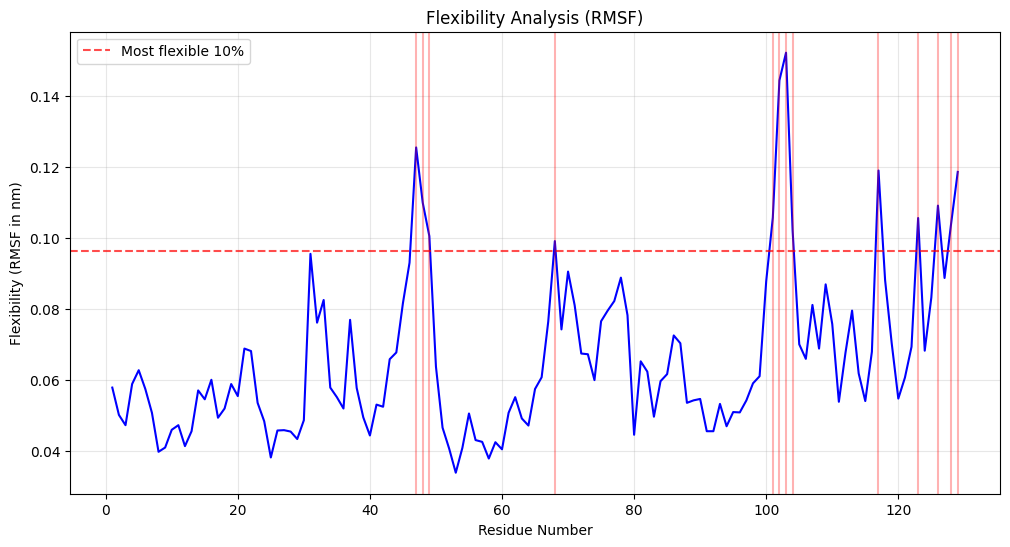

Most flexible residue: 103 (moved 0.152 nm on average)
Overall protein flexibility: 0.066 nm


In [ ]:
with open('rmsf_input.txt', 'w') as f:
    f.write('3\n')

!gmx rmsf -s md.tpr -f md.xtc -o rmsf_residue.xvg -res < rmsf_input.txt

residue_nums, rmsf_values = parse_xvg('rmsf_residue.xvg')

if len(rmsf_values) > 0:
    # Plot flexibility along the protein chain
    plt.figure(figsize=(12, 6))
    plt.plot(residue_nums, rmsf_values, 'b-', linewidth=1.5)
    plt.xlabel('Residue Number')
    plt.ylabel('Flexibility (RMSF in nm)')
    plt.title('Flexibility Analysis (RMSF)')
    plt.grid(True, alpha=0.3)

    # Highlight the most flexible regions
    flexibility_cutoff = np.percentile(rmsf_values, 90)
    flexible_regions = residue_nums[rmsf_values > flexibility_cutoff]
    plt.axhline(y=flexibility_cutoff, color='r', linestyle='--', alpha=0.7,
               label=f'Most flexible 10%')

    for region in flexible_regions:
        plt.axvline(x=region, color='red', alpha=0.3)

    plt.legend()
    plt.savefig('analysis/flexibility_analysis.png', dpi=300)
    plt.show()

    most_flexible = residue_nums[np.argmax(rmsf_values)]
    max_flexibility = np.max(rmsf_values)
    avg_flexibility = np.mean(rmsf_values)

    print(f"Most flexible residue: {int(most_flexible)} (moved {max_flexibility:.3f} nm on average)")
    print(f"Overall protein flexibility: {avg_flexibility:.3f} nm")
else:
    print("RMSF calculation failed")

## 5.2 Focusing on the Binding Pocket

Now let's look specifically at the residues that form the main binding pocket. We'll use the fpocket results to identify these residues, then see how they behaved during the simulation.

In [ ]:
# Read the pocket analysis results
static_info_file = 'pockets/static/protein_clean_info.txt'

# Parse the pocket data
pocket_info = []
with open(static_info_file, 'r') as f:
    content = f.read()

    # Split by pocket sections
    pocket_sections = content.split('Pocket')[1:]

    for i, section in enumerate(pocket_sections):
        pocket_data = {'number': i + 1}
        lines = section.strip().split('\n')

        for line in lines:
            if 'Score :' in line and 'Druggability' not in line:
                pocket_data['score'] = float(line.split(':')[1].strip().split()[0])
            elif 'Druggability Score :' in line:
                pocket_data['druggability'] = float(line.split(':')[1].strip().split()[0])
            elif 'Volume :' in line:
                pocket_data['volume'] = float(line.split(':')[1].strip().split()[0])
            elif 'Total SASA :' in line:
                pocket_data['sasa'] = float(line.split(':')[1].strip().split()[0])

        pocket_info.append(pocket_data)

# Show what we found
print("Pocket analysis found:")
for pocket in pocket_info:
    vol = pocket.get('volume', 0)
    drug_score = pocket.get('druggability', 0)
    print(f"Pocket {pocket['number']}: {vol:.0f} Ų volume, druggability {drug_score:.3f}")

Pocket analysis found:
Pocket 1: 506 Ų volume, druggability 0.112
Pocket 2: 258 Ų volume, druggability 0.001
Pocket 3: 276 Ų volume, druggability 0.005
Pocket 4: 91 Ų volume, druggability 0.001


In [ ]:
# Get the actual residues that form the main pocket
main_pocket_file = 'pockets/static/pockets/pocket1_atm.pdb'
pocket_residues = []

if os.path.exists(main_pocket_file):
    with open(main_pocket_file, 'r') as f:
        for line in f:
            if line.startswith('ATOM'):
                res_num = int(line[22:26])
                res_name = line[17:20].strip()

                # Avoid duplicates
                if not any(r['number'] == res_num for r in pocket_residues):
                    pocket_residues.append({'number': res_num, 'name': res_name})

    # Sort by residue number
    pocket_residues.sort(key=lambda x: x['number'])
    pocket_res_numbers = [res['number'] for res in pocket_residues]

    print(f"Main binding pocket contains {len(pocket_residues)} residues:")

    # Show them in groups of 5 for readability
    for i in range(0, len(pocket_residues), 5):
        group = pocket_residues[i:i+5]
        residue_names = [f"{res['name']}{res['number']}" for res in group]
        print(f"  {', '.join(residue_names)}")

Main binding pocket contains 11 residues:
  CYS76, ASN77, ILE78, ALA82, SER85
  ASP87, THR89, ALA90, ASN93, CYS94
  LYS97


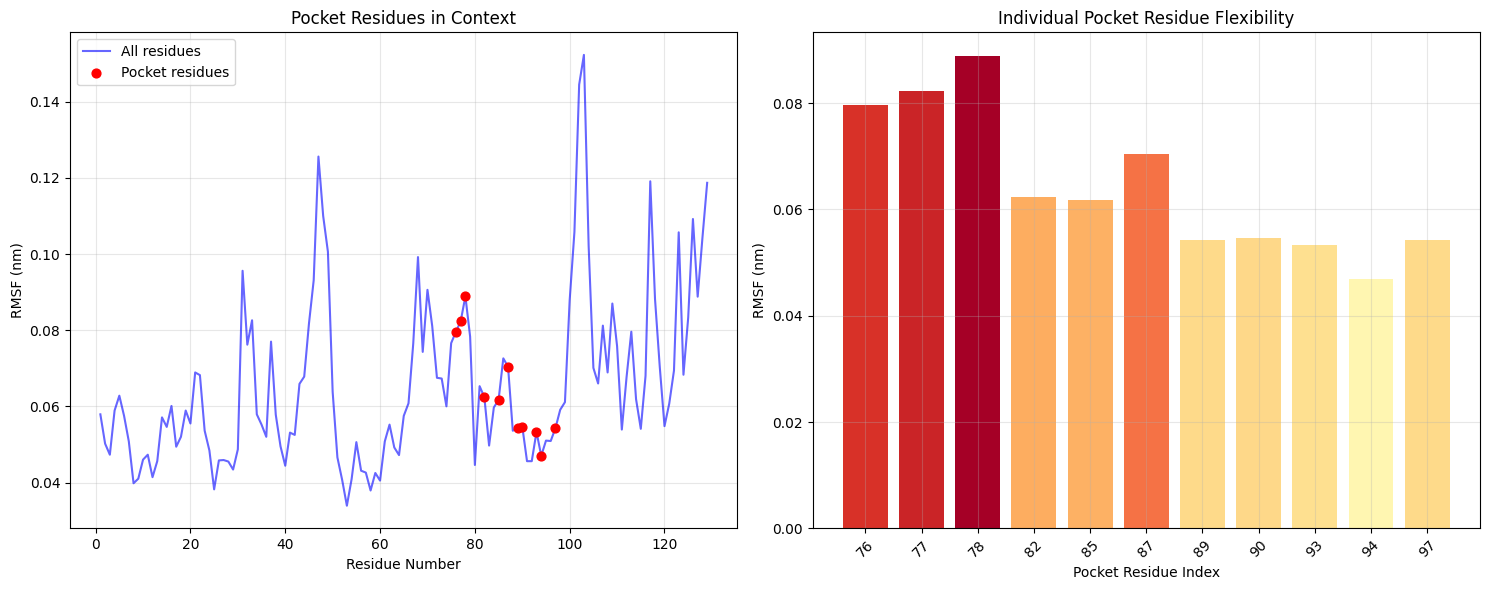

Pocket flexibility summary:
- Average pocket residue flexibility: 0.064 nm
- Compared to whole protein: 1.0x
- Most flexible pocket residue: 78 (0.089 nm)


In [ ]:
# Now analyze how flexible these pocket residues were
pocket_rmsf = []
pocket_labels = []

for res_num in pocket_res_numbers:
    # Find this residue in our flexibility data
    for i, rms_res in enumerate(residue_nums):
        if abs(rms_res - res_num) < 0.5:
            pocket_rmsf.append(rmsf_values[i])
            pocket_labels.append(res_num)
            break

pocket_rmsf = np.array(pocket_rmsf)
pocket_labels = np.array(pocket_labels)

# Create a detailed view of pocket flexibility
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Show pocket residues in context of the whole protein
ax1.plot(residue_nums, rmsf_values, 'b-', linewidth=1.5, alpha=0.6, label='All residues')
ax1.scatter(pocket_labels, pocket_rmsf, color='red', s=40, label='Pocket residues', zorder=5)
ax1.set_xlabel('Residue Number')
ax1.set_ylabel('RMSF (nm)')
ax1.set_title('Pocket Residues in Context')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Detailed view of just the pocket residues
if len(pocket_rmsf) > 0:
    colors = plt.cm.RdYlBu_r(pocket_rmsf / np.max(pocket_rmsf))
    bars = ax2.bar(range(len(pocket_labels)), pocket_rmsf, color=colors)
    ax2.set_xlabel('Pocket Residue Index')
    ax2.set_ylabel('RMSF (nm)')
    ax2.set_title('Individual Pocket Residue Flexibility')
    ax2.grid(True, alpha=0.3)

    # Label some residues
    step = max(1, len(pocket_labels) // 8)
    tick_positions = range(0, len(pocket_labels), step)
    ax2.set_xticks(tick_positions)
    ax2.set_xticklabels([str(int(pocket_labels[i])) for i in tick_positions], rotation=45)

plt.tight_layout()
plt.savefig('analysis/pocket_flexibility.png', dpi=300)
plt.show()

# Summary of pocket flexibility
if len(pocket_rmsf) > 0:
    avg_pocket_flex = np.mean(pocket_rmsf)
    avg_protein_flex = np.mean(rmsf_values)
    most_flexible_pocket_res = pocket_labels[np.argmax(pocket_rmsf)]
    max_pocket_flex = np.max(pocket_rmsf)

    relative_flexibility = avg_pocket_flex / avg_protein_flex

    print(f"Pocket flexibility summary:")
    print(f"- Average pocket residue flexibility: {avg_pocket_flex:.3f} nm")
    print(f"- Compared to whole protein: {relative_flexibility:.1f}x")
    print(f"- Most flexible pocket residue: {int(most_flexible_pocket_res)} ({max_pocket_flex:.3f} nm)")

else:
    print("No pocket residue flexibility data available")

## 5.3 Surface Accessibility Changes

Let's see how the protein's surface area changed during the simulation. This tells us about pocket opening and closing.

                 :-) GROMACS - gmx sasa, 2023.3-conda_forge (-:

Executable:   /content/miniconda3/bin.AVX2_256/gmx
Data prefix:  /content/miniconda3
Working dir:  /content/drive/MyDrive/MD_Assessment_Results
Command line:
  gmx sasa -s md.tpr -f md.xtc -o sasa_total.xvg -tu ns

Reading file md.tpr, VERSION 2023.3-conda_forge (single precision)
Reading file md.tpr, VERSION 2023.3-conda_forge (single precision)

++++ PLEASE READ AND CITE THE FOLLOWING REFERENCE ++++
Frank Eisenhaber and Philip Lijnzaad and Patrick Argos and Chris Sander and
Michael Scharf
The Double Cube Lattice Method: Efficient Approaches to Numerical Integration
of Surface Area and Volume and to Dot Surface Contouring of Molecular
Assemblies
J. Comp. Chem. 16 (1995) pp. 273-284
-------- -------- --- Thank You --- -------- --------


         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate fro

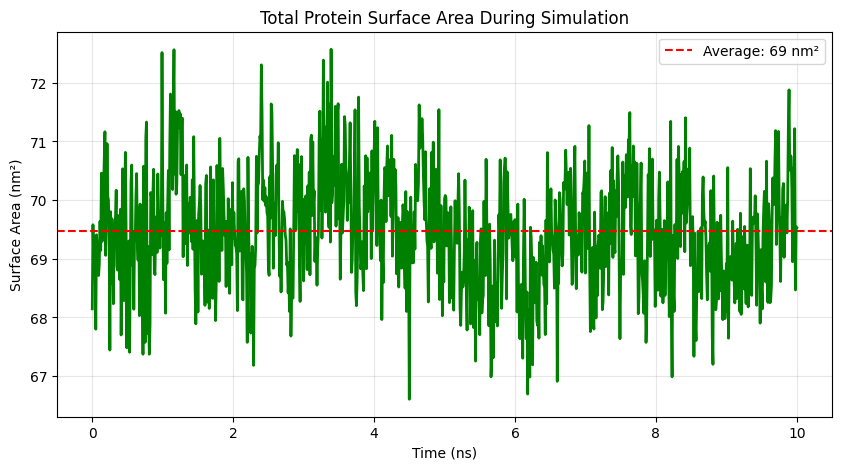

Surface area analysis:
- Started at 68 nm², ended at 70 nm²
- Overall change: 2.0%
- Variability during simulation: 1.4%


In [ ]:
# Calculate surface area changes
with open('sasa_input.txt', 'w') as f:
    f.write('1\n')

!gmx sasa -s md.tpr -f md.xtc -o sasa_total.xvg -tu ns < sasa_input.txt

time_sasa, sasa_values = parse_xvg('sasa_total.xvg')

if len(sasa_values) > 0:
    # Plot how surface area evolved
    plt.figure(figsize=(10, 5))
    plt.plot(time_sasa, sasa_values, 'g-', linewidth=2)
    plt.axhline(y=np.mean(sasa_values), color='r', linestyle='--',
               label=f'Average: {np.mean(sasa_values):.0f} nm²')
    plt.xlabel('Time (ns)')
    plt.ylabel('Surface Area (nm²)')
    plt.title('Total Protein Surface Area During Simulation')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('analysis/surface_area.png', dpi=300)
    plt.show()

    # What changed?
    initial_sasa = sasa_values[0]
    final_sasa = sasa_values[-1]
    sasa_change_percent = abs(final_sasa - initial_sasa) / initial_sasa * 100
    sasa_variability = (np.std(sasa_values) / np.mean(sasa_values)) * 100

    print(f"Surface area analysis:")
    print(f"- Started at {initial_sasa:.0f} nm², ended at {final_sasa:.0f} nm²")
    print(f"- Overall change: {sasa_change_percent:.1f}%")
    print(f"- Variability during simulation: {sasa_variability:.1f}%")

else:
    print("SASA calculation failed")

## 5.4 How Did Pockets Change Over Time?

 Let's see how the binding pockets actually behaved during the simulation by analyzing snapshots from different time points.

In [ ]:
# Extract frames every nanosecond for pocket analysis
!mkdir -p pockets/frames

frame_times = list(range(1, 11))  # 1, 2, 3, ... 10 ns

for time in frame_times:
    frame_name = f"frame_{time:02d}ns"
    with open('trjconv_input.txt', 'w') as f:
        f.write('1\n')
    !gmx trjconv -s md.tpr -f md.xtc -o pockets/frames/{frame_name}.pdb -dump {time} -tu ns < trjconv_input.txt

print(f"Extracted {len(frame_times)} frames for dynamic pocket analysis")

               :-) GROMACS - gmx trjconv, 2023.3-conda_forge (-:

Executable:   /content/miniconda3/bin.AVX2_256/gmx
Data prefix:  /content/miniconda3
Working dir:  /content/drive/MyDrive/MD_Assessment_Results
Command line:
  gmx trjconv -s md.tpr -f md.xtc -o pockets/frames/frame_01ns.pdb -dump 1 -tu ns

Note that major changes are planned in future for trjconv, to improve usability and utility.
Will write pdb: Protein data bank file
Reading file md.tpr, VERSION 2023.3-conda_forge (single precision)
Reading file md.tpr, VERSION 2023.3-conda_forge (single precision)
Select group for output
Group     0 (         System) has 33876 elements
Group     1 (        Protein) has  1960 elements
Group     2 (      Protein-H) has  1001 elements
Group     3 (        C-alpha) has   129 elements
Group     4 (       Backbone) has   387 elements
Group     5 (      MainChain) has   517 elements
Group     6 (   MainChain+Cb) has   634 elements
Group     7 (    MainChain+H) has   646 elements
Group     8

In [ ]:
import os

# Run pocket detection on each frame
dynamic_results = []

for time in frame_times:
    frame_name = f"frame_{time:02d}ns"

    # Move to frames directory and run fpocket
    os.chdir('pockets/frames')
    !fpocket -f {frame_name}.pdb > /dev/null 2>&1

    # Parse the results
    info_file = f"{frame_name}_info.txt"
    frame_data = {'time': time, 'pockets': 0, 'volume': 0, 'druggability': 0}

    if os.path.exists(info_file):
        with open(info_file, 'r') as f:
            content = f.read()

        # Count pockets and get main pocket data
        pocket_sections = content.split('Pocket')[1:]
        frame_data['pockets'] = len(pocket_sections)

        if pocket_sections:
            # Get main pocket info
            main_section = pocket_sections[0]
            for line in main_section.split('\n'):
                if 'Volume :' in line:
                    try:
                        frame_data['volume'] = float(line.split(':')[1].strip().split()[0])
                    except:
                        pass
                elif 'Druggability Score :' in line:
                    try:
                        frame_data['druggability'] = float(line.split(':')[1].strip().split()[0])
                    except:
                        pass

    dynamic_results.append(frame_data)
    os.chdir('../..')

print("Dynamic pocket analysis completed")
print(f"Analyzed {len(dynamic_results)} frames")

Dynamic pocket analysis completed
Analyzed 10 frames


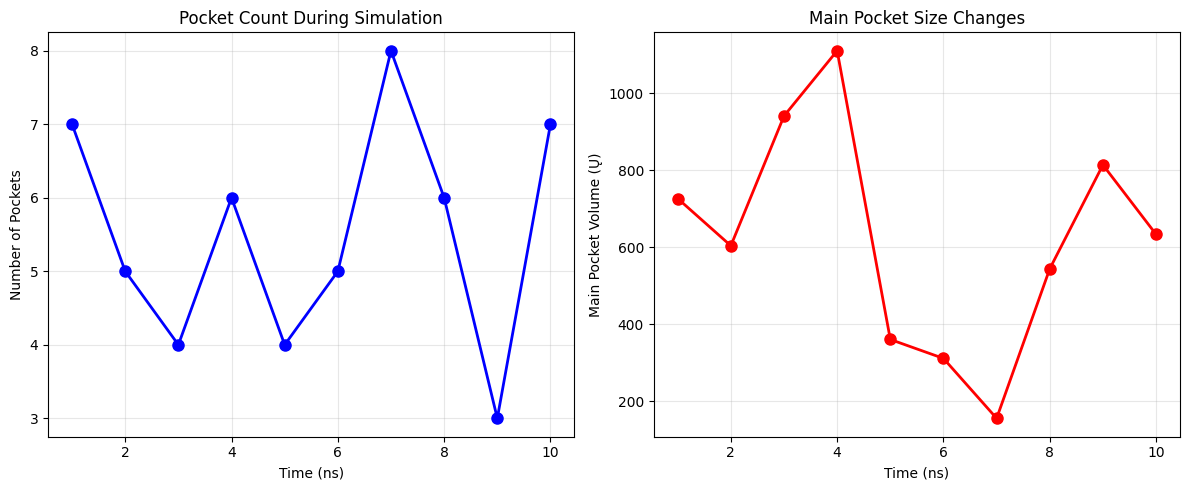

Dynamic pocket analysis results:
- Analyzed 10 time points
- Pocket count range: 3 to 8
- Average pockets per frame: 5.5
- Pocket volume ranged from 155 to 1111 Ų
- Average volume: 620 Ų
- Volume variability: 45%
- Assessment: highly dynamic - significant shape changes


In [ ]:
# Extract data for analysis with corrected file paths
dynamic_results = []

for time in frame_times:
    frame_name = f"frame_{time:02d}ns"
    output_dir = f"pockets/frames/{frame_name}_out"
    info_file = f"{output_dir}/{frame_name}_info.txt"

    frame_data = {'time': time, 'pockets': 0, 'volume': 0, 'druggability': 0}

    if os.path.exists(info_file):
        with open(info_file, 'r') as f:
            content = f.read()

        # Count pockets and get main pocket data
        pocket_sections = content.split('Pocket')[1:]
        frame_data['pockets'] = len(pocket_sections)

        if pocket_sections:
            # Get main pocket info from first pocket
            main_section = pocket_sections[0]
            for line in main_section.split('\n'):
                if 'Volume :' in line:
                    try:
                        frame_data['volume'] = float(line.split(':')[1].strip().split()[0])
                    except:
                        pass
                elif 'Druggability Score :' in line:
                    try:
                        frame_data['druggability'] = float(line.split(':')[1].strip().split()[0])
                    except:
                        pass

    dynamic_results.append(frame_data)

# Extract data for plotting
times = [r['time'] for r in dynamic_results]
pocket_counts = [r['pockets'] for r in dynamic_results]
volumes = [r['volume'] for r in dynamic_results]
druggability_scores = [r['druggability'] for r in dynamic_results]

# Plot how pockets evolved
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Pocket count over time
ax1.plot(times, pocket_counts, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Time (ns)')
ax1.set_ylabel('Number of Pockets')
ax1.set_title('Pocket Count During Simulation')
ax1.grid(True, alpha=0.3)

# Main pocket volume changes
valid_volumes = [v for v in volumes if v > 0]
valid_times = [times[i] for i, v in enumerate(volumes) if v > 0]

if valid_volumes:
    ax2.plot(valid_times, valid_volumes, 'ro-', linewidth=2, markersize=8)
    ax2.set_xlabel('Time (ns)')
    ax2.set_ylabel('Main Pocket Volume (Ų)')
    ax2.set_title('Main Pocket Size Changes')
    ax2.grid(True, alpha=0.3)
else:
    ax2.text(0.5, 0.5, 'No volume data available', ha='center', va='center', transform=ax2.transAxes)

plt.tight_layout()
plt.savefig('analysis/pocket_evolution.png', dpi=300)
plt.show()

# Analyze the results
print("Dynamic pocket analysis results:")
print(f"- Analyzed {len(dynamic_results)} time points")
print(f"- Pocket count range: {min(pocket_counts)} to {max(pocket_counts)}")
print(f"- Average pockets per frame: {np.mean(pocket_counts):.1f}")

if valid_volumes:
    volume_range = max(valid_volumes) - min(valid_volumes)
    volume_avg = np.mean(valid_volumes)
    volume_variability = (np.std(valid_volumes) / volume_avg) * 100

    print(f"- Pocket volume ranged from {min(valid_volumes):.0f} to {max(valid_volumes):.0f} Ų")
    print(f"- Average volume: {volume_avg:.0f} Ų")
    print(f"- Volume variability: {volume_variability:.0f}%")

    if volume_variability > 25:
        dynamic_assessment = "highly dynamic - significant shape changes"
    elif volume_variability > 15:
        dynamic_assessment = "moderately dynamic - some flexibility"
    else:
        dynamic_assessment = "relatively stable - minor changes"

    print(f"- Assessment: {dynamic_assessment}")
else:
    print("- No valid pocket volumes detected")
    if np.mean(pocket_counts) == 0:
        print("- No pockets found in any frame - pocket may have closed during simulation")
    else:
        print("- Pockets detected but volume data missing")

## 5.5 What This Means for Drug Design

Our analysis reveals important insights about how protein dynamics affect drug binding potential.

In [ ]:
# Druggability analysis
main_pocket = pocket_info[0] if pocket_info else {}


print(f"POCKET CHARACTERISTICS:")
static_volume = main_pocket.get('volume', 0)
static_druggability = main_pocket.get('druggability', 0)
print(f"- Main pocket volume: {static_volume:.0f} Ų")
print(f"- Druggability score: {static_druggability:.3f}")

if valid_volumes:
    print(f"- Volume range during MD: {min(valid_volumes):.0f}-{max(valid_volumes):.0f} Ų")
    print(f"- Volume variability: {volume_variability:.0f}%")

print(f"\nPROTEIN DYNAMICS:")
print(f"- Structural stability (RMSD): {final_rmsd:.2f} nm")
print(f"- Pocket flexibility: {relative_flexibility:.1f}x protein average")
print(f"- Surface area variability: {sasa_variability:.1f}%")

POCKET CHARACTERISTICS:
- Main pocket volume: 506 Ų
- Druggability score: 0.112
- Volume range during MD: 155-1111 Ų
- Volume variability: 45%

PROTEIN DYNAMICS:
- Structural stability (RMSD): 0.18 nm
- Pocket flexibility: 1.0x protein average
- Surface area variability: 1.4%


Looking at our results, this protein shows really promising characteristics for drug development. The druggability score of 0.112 puts it well into the "druggable" category. What's particularly interesting is how dynamic this pocket is during the simulation. We see the volume changing from 155 to over 1111 Ų, which is quite dramatic. This tells us the pocket isn't just a static cavity but actually reshapes itself significantly. From a drug design perspective, this creates both opportunities and headaches. On the positive side, such flexibility suggests the pocket could accommodate different types of molecules and adapt to optimize binding. However, it also means that traditional computational approaches that treat the protein as rigid probably won't capture the full picture of how drugs might bind here. The fact that we maintain overall protein stability while seeing this localized flexibility is actually ideal, we want the binding site to be adaptable without the whole protein falling apart. Also, this data suggests that ensemble docking methods that consider multiple pocket shapes from the simulation is ideal rather than just designing against a single static structure. The high flexibility also hints that fragment-based drug design might work particularly well here, since smaller molecules could more easily navigate and take advantage of the pocket's conformational changes.